# The predict pipeline

The pipeline uses the optimized predictive model (output of the `baseline` pipeline) and the conformal model (output of the `validate` pipeline) to generate predictions on pre- and post-retrofit data, adding uncertainty intervals with user-provided confidence levels. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from feature_encoders.utils import as_series

In [2]:
from eensight.utils.jupyter import load_catalog

## Load the catalog

In [3]:
catalog = load_catalog('demo', partial_catalog=True)

Predictions can be carried out for both `train` and `apply` data. 

## Predict `train` data

In [4]:
data = catalog.load('train.model_input_data')

to_drop = data.filter(like="_outlier", axis=1).columns.to_list()
if len(to_drop) > 0:
    data = data.drop(to_drop, axis=1)

y_true = None
if "consumption" in data:
    y_true = data.pop("consumption")

2021-11-18 16:34:22,685 - kedro.io.data_catalog - INFO - Loading data from `train.model_input_data` (CSVDataSet)...


Read the mean and the conformal prediction models:

In [5]:
mean_model = catalog.load('mean_model')
conformal_model = catalog.load('conformal_model')

2021-11-18 16:34:25,533 - kedro.io.data_catalog - INFO - Loading data from `mean_model` (PickleDataSet)...
2021-11-18 16:34:27,200 - numba.cuda.cudadrv.driver - INFO - init
2021-11-18 16:34:27,285 - kedro.io.data_catalog - INFO - Loading data from `conformal_model` (PickleDataSet)...


Get the prediction and add the uncertainty intervals for a specified confidence level:

In [6]:
%%time

significance = 0.9

pred_mean = mean_model.predict(data)
pred_conf = conformal_model.predict(data, significance)

prediction = pd.concat(
    (
        pred_mean[["consumption"]],
        (pred_mean["consumption"] + as_series(pred_conf)).to_frame(
            "consumption_high"
        ),
        (pred_mean["consumption"] - as_series(pred_conf)).to_frame(
            "consumption_low"
        ),
    ),
    axis=1,
)

Wall time: 13.2 s


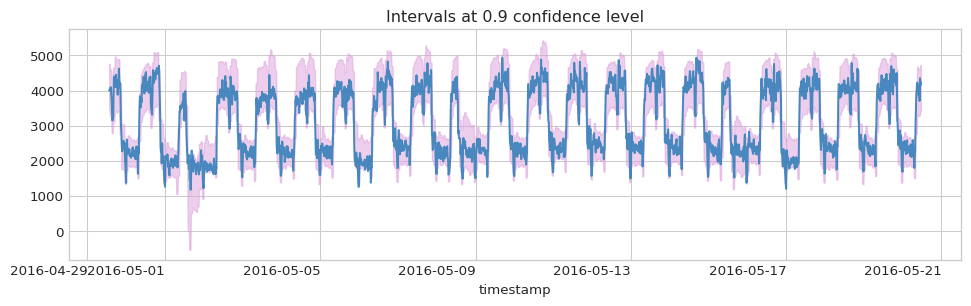

In [7]:
size=2000
title=f'Intervals at {significance} confidence level'
start = np.random.randint(0, high=len(prediction)-size)
    
with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 3.54), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))

    y_true.loc[prediction.index][start:start+size].plot(ax=ax, alpha=0.8, rot=0)
    ax.fill_between(prediction.index[start:start+size], 
                    prediction['consumption_low'][start:start+size],
                    prediction['consumption_high'][start:start+size],
                    color='#DDA0DD', alpha=0.5
    )
    
    ax.set_title(title)

Save to the catalog:

In [8]:
catalog.save('train.model_prediction', prediction)

2021-11-18 16:36:02,420 - kedro.io.data_catalog - INFO - Saving data to `train.model_prediction` (CSVDataSet)...


## Predict `apply` data

In [9]:
data = catalog.load('apply.model_input_data')

to_drop = data.filter(like="_outlier", axis=1).columns.to_list()
if len(to_drop) > 0:
    data = data.drop(to_drop, axis=1)

y_true = None
if "consumption" in data:
    y_true = data.pop("consumption")

2021-11-18 16:36:30,759 - kedro.io.data_catalog - INFO - Loading data from `apply.model_input_data` (CSVDataSet)...


Get the prediction and add the uncertainty intervals for a specified confidence level:

In [10]:
%%time

significance = 0.9

pred_mean = mean_model.predict(data)
pred_conf = conformal_model.predict(data, significance)

prediction = pd.concat(
    (
        pred_mean[["consumption"]],
        (pred_mean["consumption"] + as_series(pred_conf)).to_frame(
            "consumption_high"
        ),
        (pred_mean["consumption"] - as_series(pred_conf)).to_frame(
            "consumption_low"
        ),
    ),
    axis=1,
)

Wall time: 6.27 s


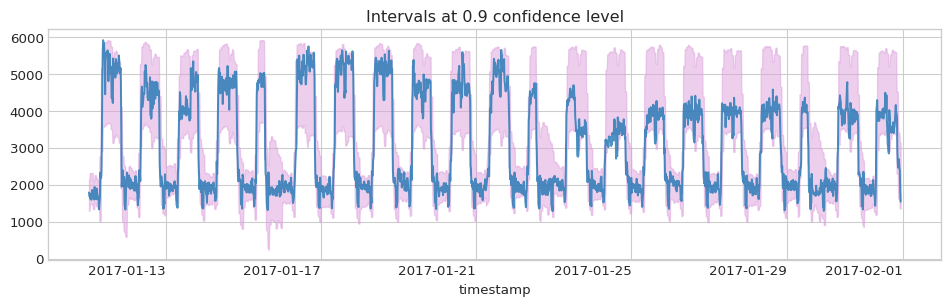

In [11]:
size=2000
title=f'Intervals at {significance} confidence level'
start = np.random.randint(0, high=len(prediction)-size)
    
with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 3.54), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))

    y_true.loc[prediction.index][start:start+size].plot(ax=ax, alpha=0.8, rot=0)
    ax.fill_between(prediction.index[start:start+size], 
                    prediction['consumption_low'][start:start+size],
                    prediction['consumption_high'][start:start+size],
                    color='#DDA0DD', alpha=0.5
    )
    
    ax.set_title(title)

Save to the catalog:

In [12]:
catalog.save('apply.model_prediction', prediction)

2021-11-18 16:37:30,587 - kedro.io.data_catalog - INFO - Saving data to `apply.model_prediction` (CSVDataSet)...


-------------------